**Import libraries**

In [13]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib . pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

**Đọc dữ liệu**

In [14]:
dataset_path = 'sentiment_analysis.csv'
df = pd.read_csv(dataset_path, index_col='id')

**Preprocessig**

**Hàm chuẩn hóa văn bản**

In [15]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT [\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?://.*[\r\n]*', '', text)

    # Hashtags removal
    text = re.sub(r'#', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)

    return text_tokens

**Hàm lưu giữ tần suất các từ**

In [16]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs

**Hàm tạo vector đặc trưng**

In [17]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X

**Trích xuất đặc trưng toàn bộ dữ liệu**

In [18]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

**Chia bộ train, val, test**

In [19]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

**Chuẩn hóa dữ liệu**

In [20]:
normalizer = StandardScaler ()
X_train [:, 1:] = normalizer . fit_transform ( X_train [:, 1:])
X_val [:, 1:] = normalizer . transform ( X_val [:, 1:])
X_test [:, 1:] = normalizer . transform ( X_test [:, 1:])

**Hàm sigmoid**

In [21]:
def sigmoid (z):
    return 1 / (1 + np.exp(-z))

**Hàm tính loss**

In [22]:
def compute_loss (y_hat , y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

**Hàm dự đoán**

In [23]:
def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

H**àm tính gradiaent**

In [24]:
def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y))/y.size

**Cập nhật trọng số**

In [25]:
def update_theta(theta , gradient , lr):
     return theta - lr * gradient

**Hàm tính độ chính xác**

In [26]:
def compute_accuracy(X, y, theta ):
    y_hat = predict(X, theta ).round ()
    acc = (y_hat == y).mean ()

    return acc

**Khai báo các siêu tham số và khởi tạo weights**

In [27]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state )
theta = np.random.uniform(size = X_train.shape[1])

**Huấn luyện mô hình**

In [28]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

    train_acc = compute_accuracy(X_train, y_train, theta)
    train_batch_accs.append(train_acc)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val_hat, y_val)
    val_batch_losses.append(val_loss)

    val_acc = compute_accuracy(X_val, y_val, theta)
    val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.707	Validation loss: 0.681

EPOCH 2:	Training loss: 0.661	Validation loss: 0.640

EPOCH 3:	Training loss: 0.624	Validation loss: 0.606

EPOCH 4:	Training loss: 0.594	Validation loss: 0.578

EPOCH 5:	Training loss: 0.569	Validation loss: 0.556

EPOCH 6:	Training loss: 0.548	Validation loss: 0.537

EPOCH 7:	Training loss: 0.531	Validation loss: 0.521

EPOCH 8:	Training loss: 0.516	Validation loss: 0.508

EPOCH 9:	Training loss: 0.504	Validation loss: 0.496

EPOCH 10:	Training loss: 0.494	Validation loss: 0.487

EPOCH 11:	Training loss: 0.485	Validation loss: 0.479

EPOCH 12:	Training loss: 0.477	Validation loss: 0.472

EPOCH 13:	Training loss: 0.471	Validation loss: 0.465

EPOCH 14:	Training loss: 0.465	Validation loss: 0.460

EPOCH 15:	Training loss: 0.460	Validation loss: 0.455

EPOCH 16:	Training loss: 0.456	Validation loss: 0.451

EPOCH 17:	Training loss: 0.452	Validation loss: 0.447

EPOCH 18:	Training loss: 0.448	Validation loss: 0.444

EPOCH 19:	Training

Visualize

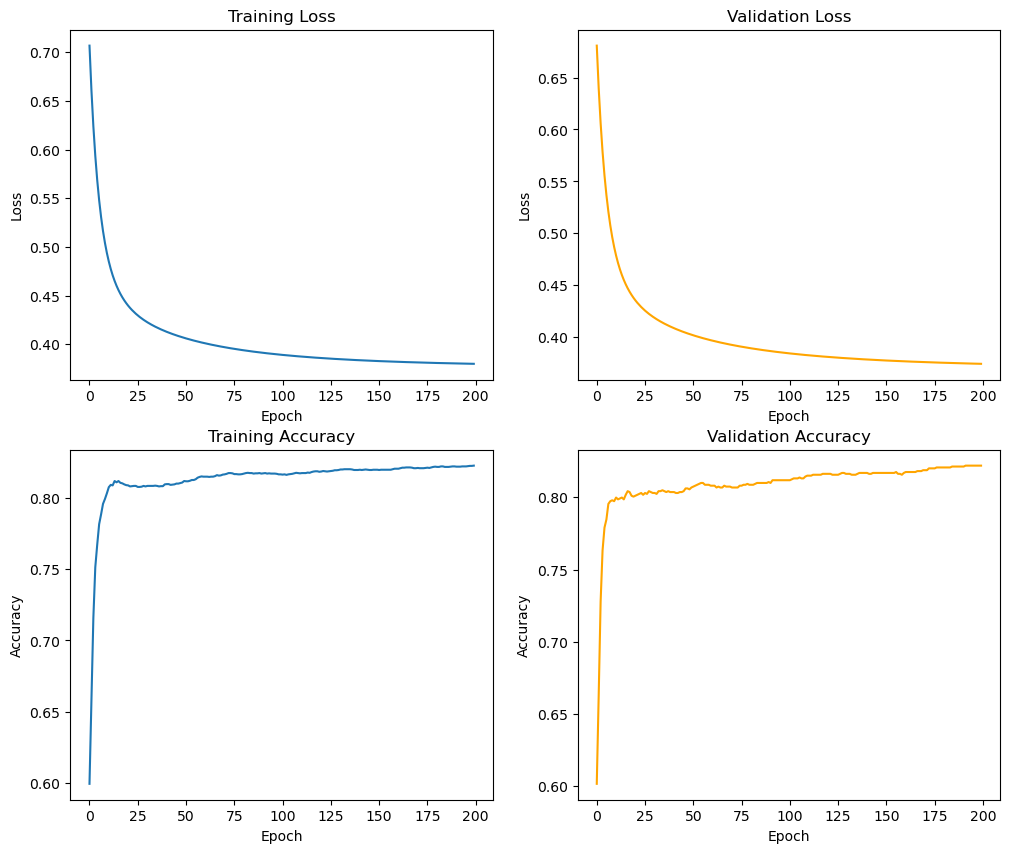

In [29]:

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()


**Đánh giá mô hình**

In [30]:
val_set_acc = compute_accuracy (X_val , y_val , theta )
test_set_acc = compute_accuracy (X_test , y_test , theta )
print ('Evaluation on validation and test set :')
print (f'Accuracy : { val_set_acc }')
print (f'Accuracy : { test_set_acc }')

Evaluation on validation and test set :
Accuracy : 0.821969696969697
Accuracy : 0.8434343434343434


In [32]:
X = np.array([22.3,-1.5,1.1,1])
theta = np.array([0.1,-0.15,0.3,-0.2])
cau_13 = predict(X,theta)
cau_13

0.9298899437785819

In [36]:
y = np.array([1, 0, 0, 1])
y_hat = np.array([0.8, 0.75, 0.3,0.95])

cau_14 = compute_loss(y,y_hat)
cau_14

5.238381154094355

In [49]:
X = np.array([[1, 2], [2, 1], [1, 1], [2, 2]])
y_true = np.array([0, 1, 0, 1])
y_pred = np.array([0.25, 0.75, 0.4, 0.8])

cau_16 = compute_gradient(X, y_true, y_pred)
cau_16

array([-0.0625,  0.0625])

In [45]:
y_true = np.array([1, 0, 1, 1])
y_pred = np.array([0.85, 0.35, 0.9, 0.75])

cau_17 = compute_accuracy(y_pred,y_true,theta)
cau_17

0.75

In [50]:
X = np.array([[1, 3], [2, 1], [3, 2], [1, 2]])
y_true = np.array([1, 0, 1, 1])
y_pred = np.array([0.7, 0.4,
0.6, 0.85])

cau_18 = compute_gradient(X,y_true,y_pred)
cau_18

array([-0.2125, -0.4   ])